## Import, preprocess and align offshore swell observations with surf height observations

This notebook outlines the preprocessing steps taken to prepare the data for surf height prediction. It was adapted from the provided preprocess_data notebook and contains more advanced feature engineering based on insights gained through EDA (notebook 01) and throughout the modelling phase (notebooks 02-07):

**-- Summary of Preprocessing Approach --**

1. Data Import:
   - Imported surf height observations and buoy data from 2010 to 2017.
   - Converted dates to datetime index and adjusted buoy data to Hawaiian local time.

2. Initial Feature Engineering:
   - Created a window_stats function to calculate statistics around daily peak wave heights (3 hours before and after peak).
   - Generated features including max, mean, and standard deviation for key variables (WVHT, DPD, APD, MWD).
   - Calculated derived features, namely, wave steepness and wave power.

3. Advanced Feature Engineering:
   - Computed rolling averages over 2-3 days for key features. (Previously test 4-5 day windows.)
   - Created interaction terms between potentially important variables.
   - Applied non-linear transformations (log, sqrt) to potentially important features (based on distribution stats).
   - Generated polynomial features (degree 2) for potentially important variables (based on mutual information regression).

4. Temporal Features:
   - Added cyclical annual features using sine and cosine transformations of the day of year.
   - Created binary indicators for Hawaiian seasons (winter/summer).

5. Data Cleaning:
   - Replaced placeholder values (99.0, 999.0, 9999.0) with NaN.
   - Dropped columns with more than 25% missing values.
   - Removed any remaining rows with missing values.

6. Feature Removal:
   - Reduced the feature space with the following statistical techniques:
      - Removed features with low correlation to the target.
      - Identified features with high correlation to each other and dropped the feature with either the lowest correlation to the target
      or, in the case of a tie, the variable with the lowest variance.
      - Removed features with low variance.

7. Final Dataset:
   - Merged surf height observations with processed buoy data -- just the target variable, 'nshor'.
   - Resulted in a clean, feature-rich dataset ready for EDA and modelling.

This preprocessing approach aims to capture complex wave dynamics, temporal patterns, and potential non-linear relationships, providing a solid foundation for predicting surf heights based on offshore buoy data.

## Import Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import PolynomialFeatures

from datetime import timedelta

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Read surf height observations
Import surf height observations and convert ymd to a date index

In [2]:
obs_dat = pd.read_table("~/Projects/surfline/data/oahu_all.dat", sep='\s+', names=["year", "month", "day", "nshor", "wshor", "almo", "dh", "winw", "wspd", "wdir", "nsd", "ssd"])
obs_dat['date'] = pd.to_datetime(obs_dat.year*10000+obs_dat.month*100+obs_dat.day,format='%Y%m%d')
obs_dat = obs_dat.set_index("date")
print(obs_dat.head)
print(obs_dat.shape)

<bound method NDFrame.head of             year  month  day  nshor  wshor  almo  dh  winw  wspd  wdir  nsd  \
date                                                                          
2010-01-01  2010      1    1      6      4     2   3     4     3     2   16   
2010-01-02  2010      1    2      7      4     2   2     3     2    17   14   
2010-01-03  2010      1    3      6      4     2   2     2     4    11   15   
2010-01-04  2010      1    4      6      3     2   2     2     4    11   14   
2010-01-05  2010      1    5     18      6     2   2     2     4    11   14   
...          ...    ...  ...    ...    ...   ...  ..   ...   ...   ...  ...   
2016-12-27  2016     12   27      4      2     1   2     4     6     5   15   
2016-12-28  2016     12   28      3      1     1   2     3     5     3   15   
2016-12-29  2016     12   29     10      2     1   1     6     4     3   16   
2016-12-30  2016     12   30      6      2     1   1     5     5     2    2   
2016-12-31  2016     1

## Import buoy data / offshore observation
Import data from the offshore sensor.

- Shift GMT into Hawaiian local time
- Remove data before and after sunset (When we presume observation would be impossible)
- Filter data to give only rows with maximum daily WVHT (commented out and replaced with new approach)

In [3]:
# Read all years and concatenate
all_dat = []
for year in range(2010, 2017):
    dat = pd.read_table("~/Projects/surfline/data/buoy_"+str(year)+".dat", sep='\s+', skiprows=3, names=["YYYY", "MM", "DD", "hh", "mm", "WDIR", "WSPD", "GST",  "WVHT", "DPD", "APD", "MWD", "PRES", "ATMP", "WTMP", "DEWP",  "VIS", "TIDE"])
    all_dat.append(dat)
dat = pd.concat(all_dat)

# Convert the date columns into a datetime index
dat['date'] = pd.to_datetime(dat.YYYY.astype(str)+"-"+dat.MM.astype(str)+"-"+dat.DD.astype(str)+" "+dat.hh.astype(str)+":"+dat.mm.astype(str)+":00")
dat = dat.set_index(pd.DatetimeIndex(dat['date']))

# The buoy data is reported in GMT but the observations are in Hawaiian time. Given the observations are 'maximum'
# value in day we don't have to be too precise here (eg. worry about DST) but we do need to shift this data.
dat.index = dat.index + timedelta(hours=-10)

# We know (or assume!) observations are taken during daylight hours. Again with the imprecision inherent in the 
# observation data we probably don't gain by over thinking this but here's a filter:
hour = dat.index.hour
selector = ((hour >= 7) & (hour <= 17))
buoy_dat = dat[selector]

# # We know the observations are for the daily largest heights. Here we'll filter our buoy data to just the daily
# # row with the largest WVHT value. This presumes WVHT is a correlate with our observed heights and that assumption
# # will predjudice our model outcomes. Feel free to use a different method!
# idx = dat.groupby(
#             ([dat.index.year, dat.index.month, dat.index.day])
#             )['WVHT'].idxmax()

# dat = dat[idx]

# idx = dat.resample('d').max()

# buoy_dat = idx

# buoy_dat = buoy_dat.replace(99.0, np.nan)

# print(buoy_dat.head)
# print(buoy_dat.shape)

## Feature Engineering

In [4]:
# Identify the time of maximum WVHT for each day
peak_times = buoy_dat.groupby(buoy_dat.index.date)['WVHT'].idxmax()

# Generate statitics across a given window before and after maximum WVHT for each day
def window_stats(group, peak_time, window_hours=3): # previously tested a 2 hour window
    window_start = peak_time - pd.Timedelta(hours=window_hours)
    window_end = peak_time + pd.Timedelta(hours=window_hours)
    window_data = group[(group.index >= window_start) & (group.index <= window_end)]
    
    # Calculate rate of change in WVHT leading up to peak
    wvht_change = (group.loc[peak_time, 'WVHT'] - window_data['WVHT'].iloc[0]) / pd.Timedelta(hours=window_hours).total_seconds()
    
    stats = {
        # Wave Height Statistics
        'WVHT_max': window_data['WVHT'].max(),
        'WVHT_mean': window_data['WVHT'].mean(),
        'WVHT_std': window_data['WVHT'].std(),
        'WVHT_rate_of_change': wvht_change,
        
        # Wave Period Statistics
        'DPD_at_peak': group.loc[peak_time, 'DPD'],
        'DPD_mean': window_data['DPD'].mean(),
        'DPD_std': window_data['DPD'].std(),
        'APD_at_peak': group.loc[peak_time, 'APD'],
        'APD_mean': window_data['APD'].mean(),
        'APD_std': window_data['APD'].std(),
        
        # Wave Direction Statistics
        'MWD_at_peak': group.loc[peak_time, 'MWD'],
        'MWD_mean': window_data['MWD'].mean(),
        'MWD_range': window_data['MWD'].max() - window_data['MWD'].min(),
        
        # Wind Statistics
        # Dropped due to there being too many missing values in WSPD and WDIR.
        # 'WSPD_max': window_data['WSPD'].max(),
        # 'WSPD_mean': window_data['WSPD'].mean(),
        # 'WDIR_at_peak': group.loc[peak_time, 'WDIR'],
        # 'WDIR_mode': window_data['WDIR'].mode().iloc[0] if not window_data['WDIR'].mode().empty else np.nan,
        
        # Composite Metrics
        'wave_steepness': window_data['WVHT'].mean() / (9.8 * (window_data['DPD'].mean() ** 2) / (2 * np.pi)),
        'wave_power': 0.5 * (window_data['WVHT'].mean() ** 2) * window_data['DPD'].mean() # this ends up being interesting!
    }
    return pd.Series(stats)

In [5]:
# Apply the window_stats function to each day's data
buoy_dat = buoy_dat.groupby(buoy_dat.index.date).apply(lambda x: window_stats(x, peak_times[x.name]))

## Advanced Features

In [6]:
# Calculate rolling averages over 2 to 3 days
# The idea behind this is that human perception data is inherintly comparitive/relative, meaning that
# recent wave sightings may be influencing current wave sightings (potentially across days!)
def rolling_average_features(df, windows_list):
    for window in windows_list:
        df[f'WVHT_max_{window}d_avg'] = df['WVHT_max'].rolling(window=window).mean()
        df[f'MWD_{window}d_avg'] = df['MWD_at_peak'].rolling(window=window).mean()
        df[f'APD_{window}d_avg'] = df['APD_at_peak'].rolling(window=window).mean()
        df[f'DPD_mean_{window}d_avg'] = df['DPD_mean'].rolling(window=window).mean()
        df[f'wave_power_{window}d_avg'] = df['wave_power'].rolling(window=window).mean()
    return df

# Generate interactions between potentially important features
def interaction_features(df):
    df['WVHT_max_MWD_interact'] = df['WVHT_max'] * df['MWD_at_peak']
    df['WVHT_max_APD_interact'] = df['WVHT_max'] * df['APD_at_peak']
    df['WVHT_max_DPD_mean_interact'] = df['WVHT_max'] * df['DPD_mean']
    df['WVHT_max_wave_power_interact'] = df['WVHT_max'] * df['wave_power']
    df['MWD_wave_power_interact'] = df['MWD_at_peak'] * df['wave_power']
    df['APD_wave_power_interact'] = df['APD_at_peak'] * df['wave_power']
    df['DPD_mean_wave_power_interact'] = df['DPD_mean'] * df['wave_power']
    return df

# Generate logical ratio features
def ratio_features(df):
    df['WVHT_max_mean_ratio'] = df['WVHT_max'] / df['WVHT_mean']
    df['APD_DPD_ratio'] = df['APD_mean'] / df['DPD_mean']
    return df

# Determine log and square root features for heavily and moderate skewed features respectively
def nonlinear_transformations(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        skewness = df[col].skew()
        if skewness > 1:
            df[f'{col}_log'] = np.log1p(df[col])
        elif 0.5 < skewness <= 1:
            df[f'{col}_sqrt'] = np.sqrt(df[col])
    return df

# Create advanced features pipeline
def advanced_features_pipe(df, windows_list):
    df = rolling_average_features(df, windows_list)
    df = interaction_features(df)
    df = ratio_features(df)
    df = nonlinear_transformations(df)
    return df

In [7]:
# Run advanced features pipeline
buoy_data = advanced_features_pipe(buoy_dat, windows_list=[2, 3])

## Merge our datasets on date
Merge the features engineered for each day from the sensor data with the target variable for that day -- max observed wave height ('nshor').

Early on in EDA (notebook 01), I noticed a correlation between 'winw' and the target variable. However, since 'winw' is also from a human observer, I have chosen to ommit it. Incidentally, there were too many missing values in the wind variables of buoy_dat, so these have been dropped as well.
Procuring reliable wind data may improve a future iteration of this study.

In [8]:
# Here I am simply grabbing the target variable from obs_dat
full_dat = pd.merge(buoy_dat, obs_dat[['nshor']], how='outer', left_index=True, right_index=True)
full_dat.columns

Index(['WVHT_max', 'WVHT_mean', 'WVHT_std', 'WVHT_rate_of_change',
       'DPD_at_peak', 'DPD_mean', 'DPD_std', 'APD_at_peak', 'APD_mean',
       'APD_std', 'MWD_at_peak', 'MWD_mean', 'MWD_range', 'wave_steepness',
       'wave_power', 'WVHT_max_2d_avg', 'MWD_2d_avg', 'APD_2d_avg',
       'DPD_mean_2d_avg', 'wave_power_2d_avg', 'WVHT_max_3d_avg', 'MWD_3d_avg',
       'APD_3d_avg', 'DPD_mean_3d_avg', 'wave_power_3d_avg',
       'WVHT_max_MWD_interact', 'WVHT_max_APD_interact',
       'WVHT_max_DPD_mean_interact', 'WVHT_max_wave_power_interact',
       'MWD_wave_power_interact', 'APD_wave_power_interact',
       'DPD_mean_wave_power_interact', 'WVHT_max_mean_ratio', 'APD_DPD_ratio',
       'WVHT_max_log', 'WVHT_mean_log', 'WVHT_std_log',
       'WVHT_rate_of_change_log', 'DPD_at_peak_log', 'DPD_std_log',
       'APD_at_peak_log', 'APD_mean_sqrt', 'APD_std_log', 'MWD_range_log',
       'wave_steepness_sqrt', 'wave_power_log', 'WVHT_max_2d_avg_log',
       'APD_2d_avg_log', 'wave_power_2d_

## Handle Missing Values

In [9]:
# The below steps were being taken before I decided to omit all obs_dat aside from the target variable

# Inspecting suspicious values based on data types
# all_dat.ssd.value_counts()

# The ssd column should be floats, but is instead strings, some of which are bad labels entirely
# This step eventually became redundant, because the ssd column contains too many missing values to keep anyway
# all_dat.loc[all_dat['ssd'] == '999\', 'ssd'] = '999'
# all_dat['ssd'] = all_dat['ssd'].astype(float)

In [11]:
# Handle both replacing placeholder values and drop columns with too many placeholders
def handle_missing_values(df, placeholders=[99, 999, 9999], drop_threshold=25.0):
    # Extend placeholders to cover both numeric and string representations
    str_placeholders = [str(p) for p in placeholders]
    all_placeholders = placeholders + str_placeholders
    
    # Replace all placeholder values with NaN (whether int, float, or string)
    df = df.replace(all_placeholders, np.nan)
    
    # Check each column for percentage of NaN values and drop if exceeds threshold
    for col in df.columns:
        missing_pct = df[col].isna().mean() * 100  # Percentage of missing (NaN) values
        
        if missing_pct > drop_threshold:
            print(f"Dropping column '{col}' due to {missing_pct:.2f}% missing values.")
            df = df.drop(col, axis=1)
    
    return df

In [12]:
# Run handle missing values pipeline
full_dat = handle_missing_values(full_dat)

# Drop rows with any remaining missing values
full_dat = full_dat.dropna()

# Print the shape and check remaining missing values
print(f"Shape of full_dat after handling missing values: {full_dat.shape}")

for col in full_dat.columns:
    print(f"{col}: {full_dat[col].isna().sum()} missing values")

Shape of all_dat after handling missing values: (2480, 61)
WVHT_max: 0 missing values
WVHT_mean: 0 missing values
WVHT_std: 0 missing values
WVHT_rate_of_change: 0 missing values
DPD_at_peak: 0 missing values
DPD_mean: 0 missing values
DPD_std: 0 missing values
APD_at_peak: 0 missing values
APD_mean: 0 missing values
APD_std: 0 missing values
MWD_at_peak: 0 missing values
MWD_mean: 0 missing values
MWD_range: 0 missing values
wave_steepness: 0 missing values
wave_power: 0 missing values
WVHT_max_2d_avg: 0 missing values
MWD_2d_avg: 0 missing values
APD_2d_avg: 0 missing values
DPD_mean_2d_avg: 0 missing values
wave_power_2d_avg: 0 missing values
WVHT_max_3d_avg: 0 missing values
MWD_3d_avg: 0 missing values
APD_3d_avg: 0 missing values
DPD_mean_3d_avg: 0 missing values
wave_power_3d_avg: 0 missing values
WVHT_max_MWD_interact: 0 missing values
WVHT_max_APD_interact: 0 missing values
WVHT_max_DPD_mean_interact: 0 missing values
WVHT_max_wave_power_interact: 0 missing values
MWD_wave_pow

## Polynomial Features

In [13]:
# Select polynomial feature candidates based on relationship between features and the target
# Use of mutual_information_regression requires this to take place after handling missing features
def select_polynomial_candidates(X, y, mi_threshold=0.05, top_n=6, visualise=False):
    # Compute mutual information between each feature and the target
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
    
    # Select features based on threshold or top_n
    if top_n is not None:
        selected_features = mi_scores.head(top_n).index.tolist()
    else:
        selected_features = mi_scores[mi_scores > mi_threshold].index.tolist()

    # Visualise the MI scores (optional)
    if visualise:
        plt.figure(figsize=(10, 6))
        mi_scores.plot(kind='bar')
        plt.title('Mutual Information Scores of Features')
        plt.ylabel('Mutual Information Score')
        plt.xlabel('Features')
        plt.xticks(rotation=90)
        plt.show()

    return selected_features, mi_scores

In [14]:
# Generate polynomial features for selected features
def add_targeted_polynomials(df, columns, degree=2):
    poly = PolynomialFeatures(degree=degree, include_bias=False)
        
    for col in columns:
        # Create polynomial features for a single column
        poly_features = poly.fit_transform(df[[col]])
        
        # Name the new features
        feature_names = [f"{col}^{i}" for i in range(2, degree+1)]
        
        # Add new polynomial features to the dataframe
        df = pd.concat([df, pd.DataFrame(poly_features[:, 1:], columns=feature_names, index=df.index)], axis=1)
    
    return df

In [15]:
# Create polynomial features pipeline
def polynomial_features_pipe(df, target, mi_threshold=0.05, top_n=5, poly_degree=2, visualise_mi=False):
    # Prepare the feature matrix (X) and target (y)
    X = df.drop(columns=target)
    y = df[target]
    
    # Identify candidate features for polynomial expansion
    selected_features, _ = select_polynomial_candidates(X, y, mi_threshold=mi_threshold, top_n=top_n, visualise=visualise_mi)
    
    # Add polynomial features for the selected candidates
    df = add_targeted_polynomials(df, selected_features, degree=poly_degree)
    
    return df

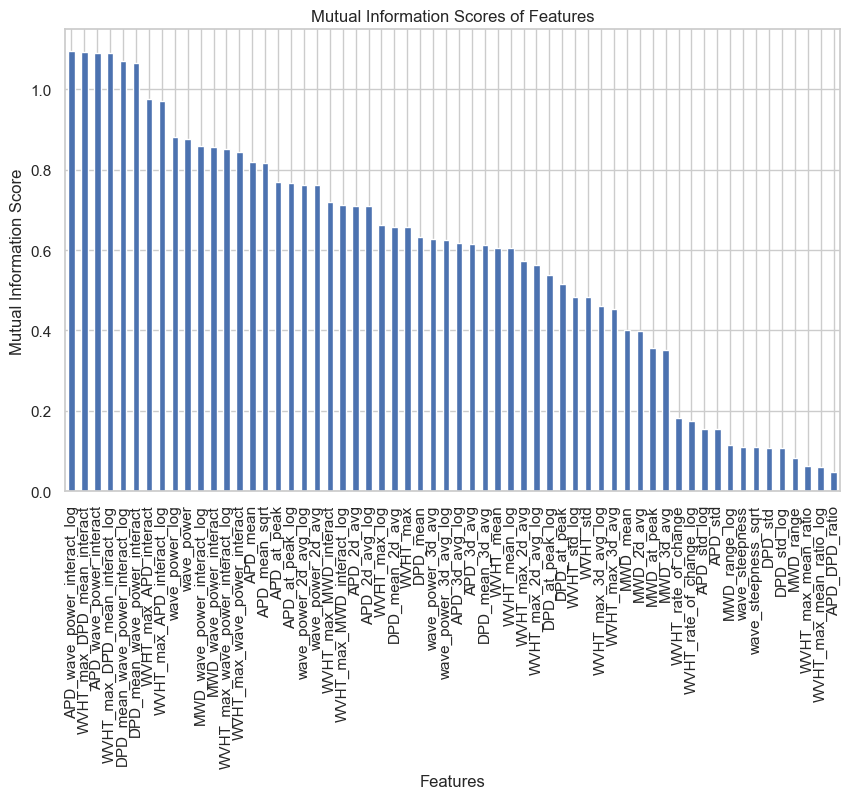

In [16]:
# Run polynomial features pipeline
full_dat = polynomial_features_pipe(full_dat, target='nshor', mi_threshold=0.05, top_n=10, poly_degree=2, visualise_mi=True)

## Annual Features

In [17]:
# Generate annual features based on day of the year
def add_annual_features(df):
    # Capture cyclical annual features
    df['day_sin'] = np.sin(df.index.dayofyear * (2 * np.pi / 365.25))
    df['day_cos'] = np.cos(df.index.dayofyear * (2 * np.pi / 365.25))

    # Capture Hawaiian seasons
    df['season'] = pd.cut(df.index.month, 
                        bins=[0, 4, 10, 12], 
                        labels=['Winter', 'Summer', 'Winter'], 
                        include_lowest=True,
                        ordered=False)

    # Create boolean columns for seasons
    df['is_summer'] = (df['season'] == 'Summer').astype(int)
    df['is_winter'] = (df['season'] == 'Winter').astype(int)

    # Drop the original 'season' column
    df = df.drop('season', axis=1)

    return df

In [18]:
# Run annual features pipeline
full_dat = add_annual_features(full_dat)

In [19]:
full_dat.dtypes

WVHT_max                       float64
WVHT_mean                      float64
WVHT_std                       float64
WVHT_rate_of_change            float64
DPD_at_peak                    float64
                                ...   
WVHT_max_APD_interact_log^2    float64
day_sin                        float64
day_cos                        float64
is_summer                        int64
is_winter                        int64
Length: 73, dtype: object

In [20]:
full_dat.columns

Index(['WVHT_max', 'WVHT_mean', 'WVHT_std', 'WVHT_rate_of_change',
       'DPD_at_peak', 'DPD_mean', 'DPD_std', 'APD_at_peak', 'APD_mean',
       'APD_std', 'MWD_at_peak', 'MWD_mean', 'MWD_range', 'wave_steepness',
       'wave_power', 'WVHT_max_2d_avg', 'MWD_2d_avg', 'APD_2d_avg',
       'DPD_mean_2d_avg', 'wave_power_2d_avg', 'WVHT_max_3d_avg', 'MWD_3d_avg',
       'APD_3d_avg', 'DPD_mean_3d_avg', 'wave_power_3d_avg',
       'WVHT_max_MWD_interact', 'WVHT_max_APD_interact',
       'WVHT_max_DPD_mean_interact', 'WVHT_max_wave_power_interact',
       'MWD_wave_power_interact', 'APD_wave_power_interact',
       'DPD_mean_wave_power_interact', 'WVHT_max_mean_ratio', 'APD_DPD_ratio',
       'WVHT_max_log', 'WVHT_mean_log', 'WVHT_std_log',
       'WVHT_rate_of_change_log', 'DPD_at_peak_log', 'DPD_std_log',
       'APD_at_peak_log', 'APD_mean_sqrt', 'APD_std_log', 'MWD_range_log',
       'wave_steepness_sqrt', 'wave_power_log', 'WVHT_max_2d_avg_log',
       'APD_2d_avg_log', 'wave_power_2d_

## Feature Removal

In [21]:
# Remove features with low correlation to the target variable
def remove_low_correlation_features(df, target, threshold):
    correlations = df.corr()[target].abs()
    low_corr_features = correlations[correlations < threshold].index.tolist()
    
    if target in low_corr_features:
        low_corr_features.remove(target)  # Ensure the target variable isn't removed
    
    print(f"Features to drop due to low correlation: {low_corr_features}")
    df_filtered = df.drop(columns=low_corr_features)
    print(f"Removed {len(low_corr_features)} features with correlation < {threshold}")
    return df_filtered

# Remove one feature between pairs of highly correlated features
def remove_highly_correlated_features(df, target, threshold):
    # Drop the target variable from the correlation matrix
    corr_matrix = df.drop(columns=[target]).corr().abs()
    
    # Create an upper triangle matrix to avoid duplicate checks
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Calculate correlation with the target variable
    target_corr = df.corr()[target].abs()

    # To store the features that will be dropped
    to_drop = set()
    
    for column in upper.columns:
        # Identify pairs of features with correlation above threshold
        high_corr_features = [row for row in upper.index if upper.loc[row, column] > threshold]
        
        # If any highly correlated features are found
        for feature in high_corr_features:
            if feature not in to_drop:
                # Compare correlation with the target and drop the one with weaker correlation
                if target_corr[column] > target_corr[feature]:
                    to_drop.add(feature)  # Drop the feature with weaker correlation to target
                elif target_corr[column] < target_corr[feature]:
                    to_drop.add(column)   # Drop the current column
                else:
                    # If correlations are equal, use variance as a tie-breaker
                    if df[column].var() > df[feature].var():
                        to_drop.add(feature)  # Drop the feature with lower variance
                    else:
                        to_drop.add(column)   # Drop current column instead

    print(f"Features to drop due to high correlation: {to_drop}")
    
    # Drop the highly correlated columns from the original dataframe (not affecting the target variable)
    df_filtered = df.drop(columns=to_drop)
    
    print(f"Removed {len(to_drop)} features with correlation > {threshold}")
    
    return df_filtered

# Remove features with low variance
def remove_low_variance_features(df, threshold):
    variances = df.var()
    low_var_features = variances[variances < threshold].index.tolist()
    
    print(f"Features to drop due to low variance: {low_var_features}")
    df_filtered = df.drop(columns=low_var_features)
    print(f"Removed {len(low_var_features)} features with variance < {threshold}")
    return df_filtered

# Create feature selection pipeline
def feature_selection_pipeline(df, target='nshor', low_corr_thresh=0.3, high_corr_thresh=0.96, low_var_thresh=0.03):
    df = remove_low_correlation_features(df, target, low_corr_thresh)
    df = remove_highly_correlated_features(df, target, high_corr_thresh)
    df = remove_low_variance_features(df, low_var_thresh)
    return df

Features to drop due to low correlation: ['DPD_std', 'MWD_range', 'wave_steepness', 'APD_DPD_ratio', 'DPD_std_log', 'MWD_range_log', 'wave_steepness_sqrt', 'day_sin']
Removed 8 features with correlation < 0.3
Features to drop due to high correlation: {'APD_wave_power_interact^2', 'DPD_mean_wave_power_interact_log', 'APD_std', 'WVHT_max_MWD_interact_log', 'WVHT_mean', 'wave_power_3d_avg_log', 'WVHT_mean_log', 'WVHT_rate_of_change', 'WVHT_max_DPD_mean_interact^2', 'APD_at_peak', 'DPD_at_peak_log', 'APD_3d_avg_log', 'is_summer', 'WVHT_max_wave_power_interact', 'wave_power_log', 'APD_wave_power_interact_log', 'WVHT_std', 'WVHT_max_APD_interact_log', 'WVHT_max_DPD_mean_interact_log^2', 'APD_wave_power_interact', 'APD_at_peak_log', 'WVHT_max_wave_power_interact_log', 'WVHT_max_APD_interact', 'APD_mean_sqrt', 'WVHT_max_DPD_mean_interact_log', 'WVHT_max_mean_ratio', 'DPD_mean_wave_power_interact', 'APD_wave_power_interact_log^2', 'MWD_wave_power_interact', 'DPD_mean_wave_power_interact_log^2',

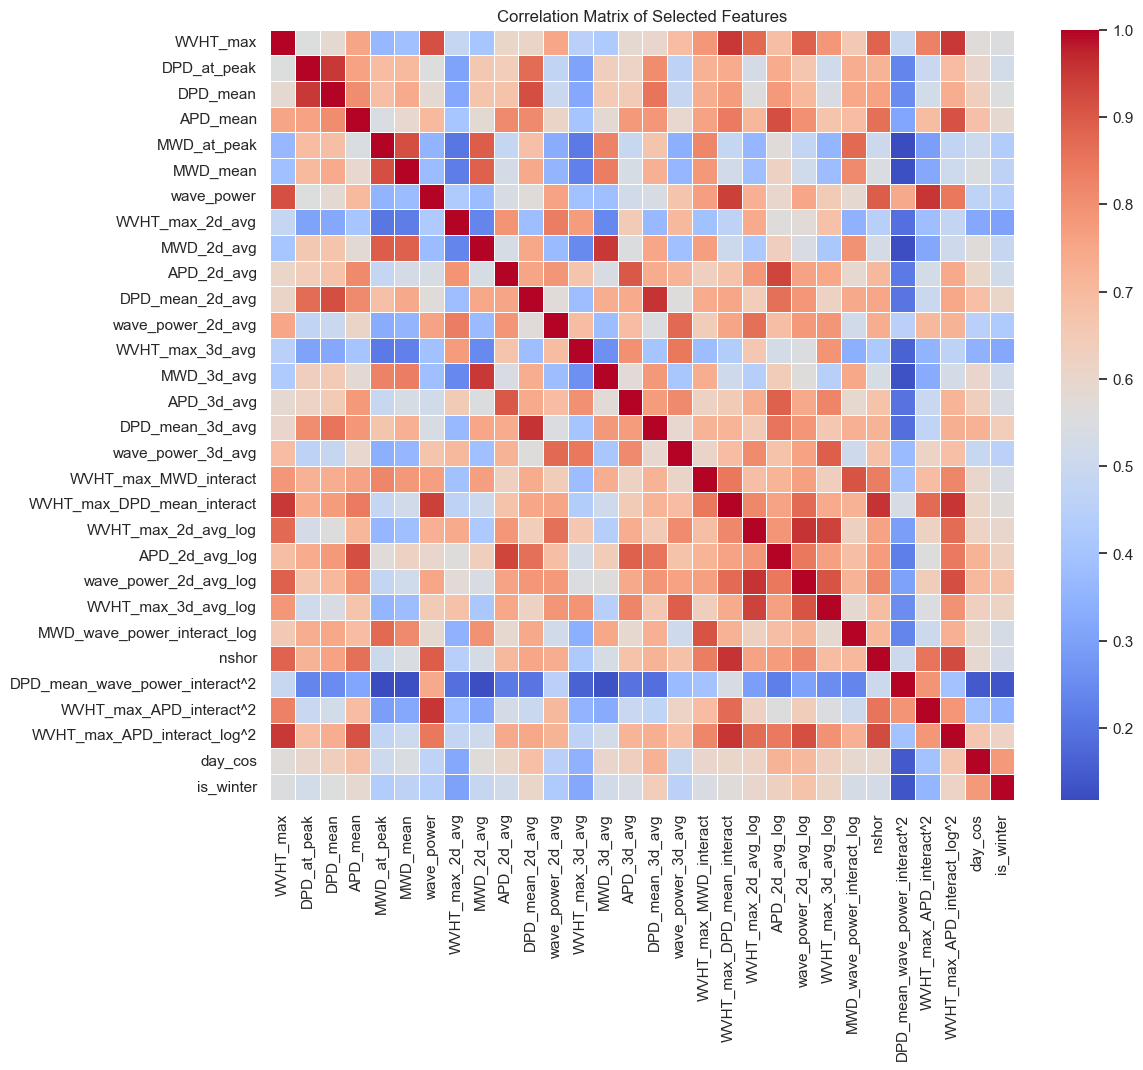

In [22]:
# Run feature selection pipeline
filtered_dat = full_dat.copy()
filtered_dat = feature_selection_pipeline(filtered_dat, target='nshor')

print(f"Original number of features: {full_dat.shape[1]-1}")
print(f"Number of features after selection: {filtered_dat.shape[1]-1}")

# Visualise correlation matrix of remaining features
plt.figure(figsize=(12, 10))
sns.heatmap(filtered_dat.corr(), annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Selected Features')
plt.show()

## Visualise / Check the Data
Plotting timeseries from both WVHT and nshore shows some correlation - enough to suggest we're on the right track
but with more than enough variance to suggest that a successful model might want to investigate other features eg DPD

In [23]:
# Verify the final data quality
print(f"Final data shape: {filtered_dat.shape}")
print(filtered_dat.info())
print(filtered_dat.describe())

print(filtered_dat.iloc[200:400]['WVHT_max'])
print(filtered_dat.iloc[200:400]['nshor'])

Final data shape: (2480, 30)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2480 entries, 2010-01-02 to 2016-12-31
Data columns (total 30 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   WVHT_max                        2480 non-null   float64
 1   DPD_at_peak                     2480 non-null   float64
 2   DPD_mean                        2480 non-null   float64
 3   APD_mean                        2480 non-null   float64
 4   MWD_at_peak                     2480 non-null   float64
 5   MWD_mean                        2480 non-null   float64
 6   wave_power                      2480 non-null   float64
 7   WVHT_max_2d_avg                 2480 non-null   float64
 8   MWD_2d_avg                      2480 non-null   float64
 9   APD_2d_avg                      2480 non-null   float64
 10  DPD_mean_2d_avg                 2480 non-null   float64
 11  wave_power_2d_avg               2480 non-null   

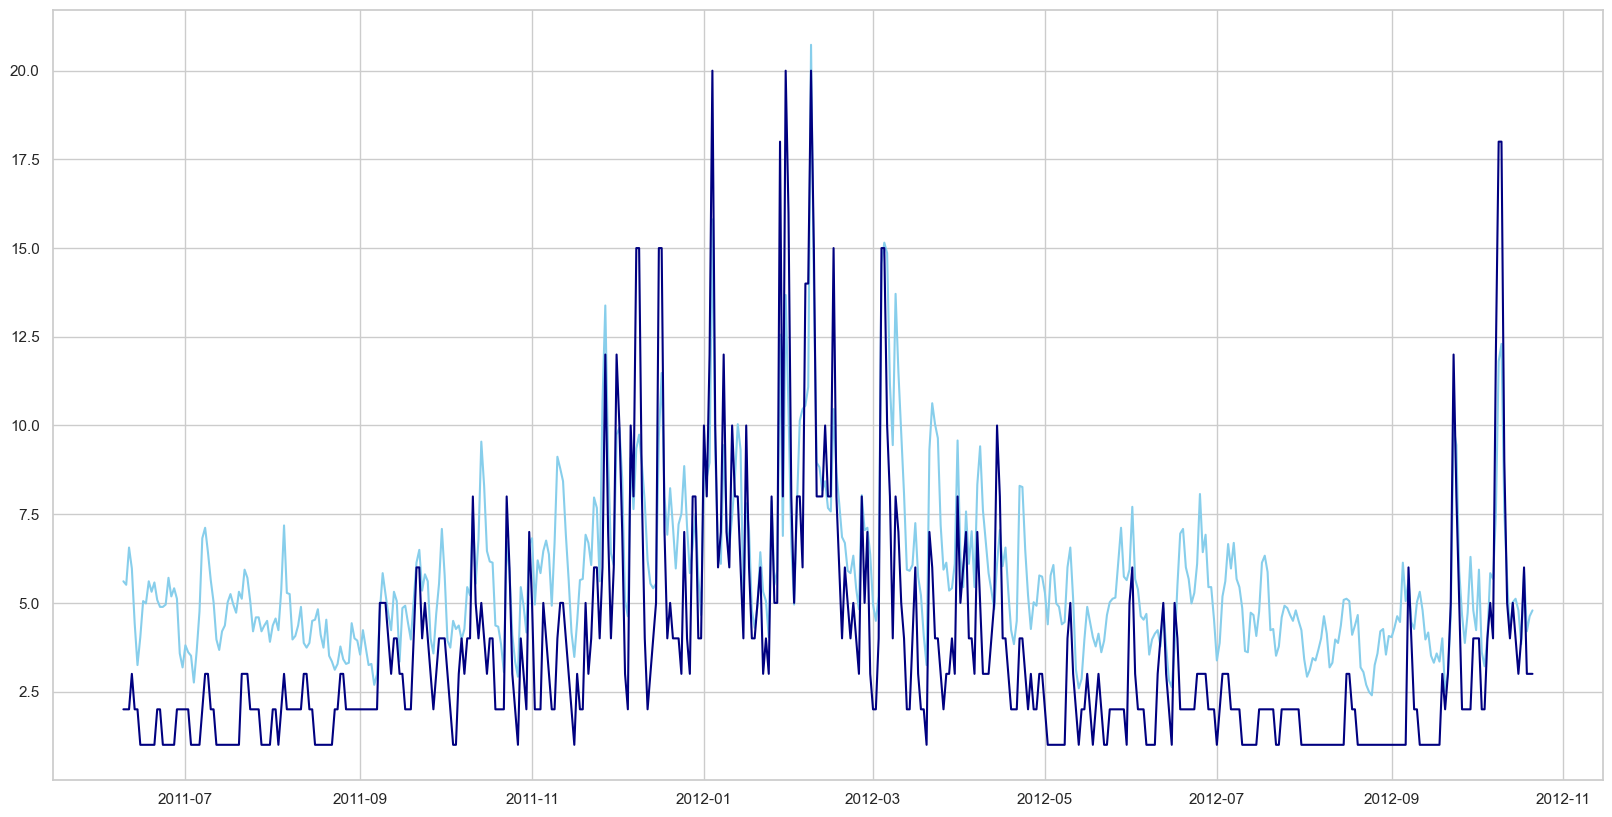

In [24]:
plt.figure(figsize=(20,10))

test_WVHT = filtered_dat['WVHT_max'][500:1000] * 3.28 # NB Converted Meters to Feet
test_nshor = filtered_dat['nshor'][500:1000]
plt.plot(test_WVHT, color='skyblue') # Convert meters to feet
plt.plot(test_nshor, color='navy') # Observations are half actual face height

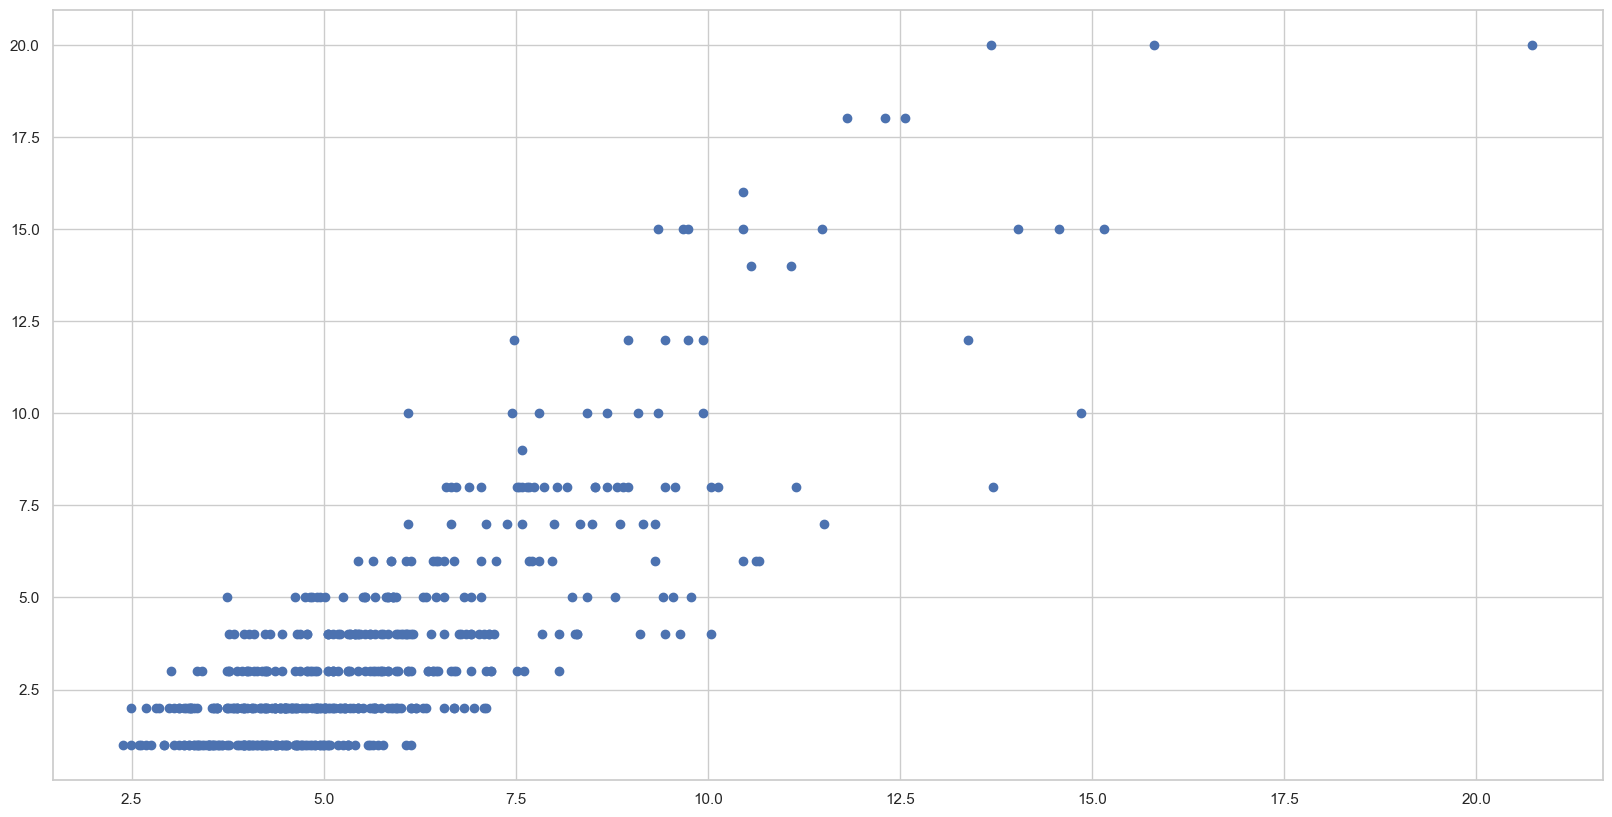

In [25]:
plt.figure(figsize=(20,10))
plt.scatter(test_WVHT, test_nshor)

In [26]:
filtered_dat.to_csv("~/Projects/surfline/data/preprocessed.dat", index=True)